<a href="https://colab.research.google.com/github/sidnb13/moonshots/blob/master/kernels/triton_kernels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import triton
import triton.language as tl

In [2]:
@triton.jit
def conv1d_loop_kernel(A, B, C, N: tl.constexpr, K: tl.constexpr):
    res = tl.zeros((N,), dtype=tl.float32)

    for i in range(N):
        offs = tl.arange(0, K)
        a_range = i + offs
        b_range = offs
        a = tl.load(A + a_range)
        b = tl.load(B + b_range)
        tl.store(C + i, tl.sum(a * b))

In [3]:
N, K   = 1024, 64
device = 'cuda'
# A is exactly length N
A = torch.randn((N,), device=device, dtype=torch.float32)
B = torch.randn((K,), device=device, dtype=torch.float32)
C = torch.empty((N,), device=device, dtype=torch.float32)

# one Triton program does the whole loop
grid = lambda META: (1,)

conv1d_loop_kernel[grid](A, B, C, N, K) # type: ignore
torch.cuda.synchronize()

# torch no-pad ⇒ valid conv ⇒ length = N-K+1
expected = torch.nn.functional.conv1d(
    A[None,None,:], B[None,None,:], padding=0
).view(-1)
# compare the first N-K+1 entries of C
assert C.shape[0] >= expected.shape[0]
assert torch.allclose(C[: expected.shape[0]], expected, atol=1e-5, rtol=1e-3)


In [4]:
@triton.jit
def conv1d_tile_kernel(A, B, C, N: tl.constexpr, K: tl.constexpr, BLOCK: tl.constexpr):
    # More efficient: launch a program per tile for vectorization
    pid = tl.program_id(0)
    offs = tl.arange(0, BLOCK)
    idx = pid * BLOCK + offs
    mask = idx < N

    window = idx[:, None] + tl.arange(0, K)[None, :]

    a = tl.load(A + window, mask[:, None]) # [BLOCK, K]
    b = tl.load(B + tl.arange(0, K)) # [K]

    c = tl.sum(a * b, axis=1)
    tl.store(C + idx, c, mask)



In [5]:
N, K   = 1024, 64
device = 'cuda'
# A is exactly length N
A = torch.randn((N,), device=device, dtype=torch.float32)
B = torch.randn((K,), device=device, dtype=torch.float32)
C = torch.empty((N,), device=device, dtype=torch.float32)

BLOCK = 32

# one Triton program does the whole loop
grid = lambda META: ((N + BLOCK - 1)//BLOCK,)

conv1d_tile_kernel[grid](A, B, C, N, K, BLOCK) # type: ignore
torch.cuda.synchronize()

# torch no-pad ⇒ valid conv ⇒ length = N-K+1
expected = torch.nn.functional.conv1d(
    A[None,None,:], B[None,None,:], padding=0
).view(-1)
# compare the first N-K+1 entries of C
assert C.shape[0] >= expected.shape[0]
assert torch.allclose(C[: expected.shape[0]], expected, atol=1e-5, rtol=1e-3)


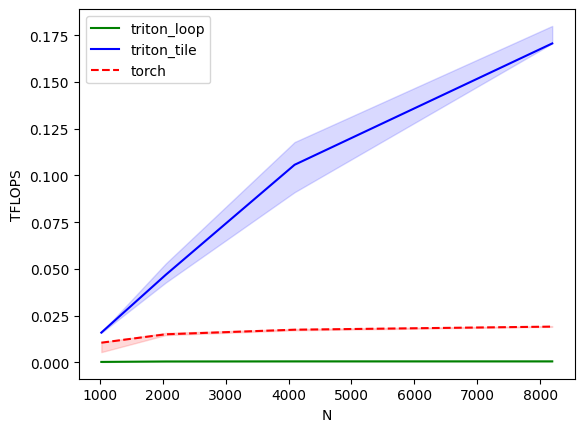

conv1d_multi:
        N  triton_loop  triton_tile     torch
0  1024.0     0.000183     0.015876  0.010476
1  2048.0     0.000427     0.046811  0.014976
2  4096.0     0.000485     0.105703  0.017430
3  8192.0     0.000487     0.170667  0.019084


In [6]:
dtype     = torch.float32
providers = ["triton_loop", "triton_tile", "torch"]
configs   = [triton.testing.Benchmark(
    x_names=["N"],
    x_vals=[2**i for i in range(10, 14)],   # 1024,2048,4096,8192
    line_arg="provider",
    line_vals=providers,
    line_names=providers,
    styles=[("green","-"),("blue","-"),("red","--")],
    ylabel="TFLOPS",
    plot_name="conv1d_multi",
    args={},                                # required
)]

@triton.testing.perf_report(configs)
def benchmark(N, provider):
    K     = 64
    BLOCK = 128
    # prepare inputs
    A = torch.randn((N,), device='cuda', dtype=dtype) / N
    B = torch.randn((K,), device='cuda', dtype=dtype) / K
    C = torch.empty_like(A)
    qs = [0.5, 0.2, 0.8]

    # pick your function based on provider
    if provider == "triton_loop":
        fn = lambda: conv1d_loop_kernel[(1,)](A, B, C, N, K)
    elif provider == "triton_tile":
        grid = lambda meta: ((N + BLOCK - 1) // BLOCK, )
        fn   = lambda: conv1d_tile_kernel[grid](A, B, C, N, K, BLOCK)
    else:  # torch baseline
        fn = lambda: torch.nn.functional.conv1d(
            A[None,None,:], B[None,None,:], padding=K-1
        ).view(-1)

    ms, mn, mx = triton.testing.do_bench(fn, quantiles=qs)
    flops      = N * K * 2
    perf       = lambda t: flops * 1e-12 / (t * 1e-3)
    return perf(ms), perf(mx), perf(mn)

# run everything
benchmark.run(show_plots=True, print_data=True)


this only gives host-level traces

In [29]:
from torch.profiler import profile, record_function, ProfilerActivity, schedule

def export_chrome_trace_with_warmup(
    N=4096, K=64, BLOCK=128, trace_path="conv_trace.json"
):
    A = torch.randn((N,), device="cuda")/N
    B = torch.randn((K,), device="cuda")/K
    C = torch.empty_like(A)
    # warmup
    conv1d_loop_kernel[(1,)](A, B, C, N, K); torch.cuda.synchronize()
    grid = ((N + BLOCK - 1)//BLOCK,)
    conv1d_tile_kernel[grid](A, B, C, N, K, BLOCK); torch.cuda.synchronize()
    torch.nn.functional.conv1d(
        A[None,None,:], B[None,None,:], padding=K-1
    ).view(-1); torch.cuda.synchronize()

    # record *3* regions = active=3
    prof_sched = schedule(wait=0, warmup=0, active=3, repeat=1)
    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        schedule=prof_sched,
        record_shapes=True,
        with_stack=False,
        on_trace_ready=lambda p: p.export_chrome_trace(trace_path),
    ) as prof:
        with record_function("triton_loop"):
            conv1d_loop_kernel[(1,)](A, B, C, N, K)
        prof.step()

        with record_function("triton_tile"):
            conv1d_tile_kernel[grid](A, B, C, N, K, BLOCK)
        prof.step()

        with record_function("torch_conv1d"):
            torch.nn.functional.conv1d(
                A[None,None,:], B[None,None,:], padding=K-1
            ).view(-1)
        prof.step()

    print(f"wrote chrome trace → {trace_path}")

# run it
export_chrome_trace_with_warmup()


wrote chrome trace → conv_trace.json
